In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

In [11]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False

In [12]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기
ginput = Input(shape = (100, ))

dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [13]:
import os

In [16]:
os.mkdir("gan_images")

In [17]:
os.listdir()

['housing.csv',
 'sonar.csv',
 'ThoraricSurgery.csv',
 'wine.csv',
 'pima-indians-diabetes.csv',
 'iris.csv',
 'gan_images']

In [22]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

# MNIST 데이터 불러오기
  # 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 호출
  (X_train, _), (_, _) = mnist.load_data()
  
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float32)
  # 127.5를 빼준 뒤 127.5로 나눠서 -1 ~ 1 사이의 값으로 바꿈
  X_train = (X_train - 127.5) / 127.5
  true = np.ones((batch_size , 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print("epoch:%d" % i, " d_loss:%.4f" % d_loss, " g_loss:%.4f" % g_loss)

      # 중간 과정을 이미지로 저장하는 부분, 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에
      # 저장하라는 뜻. 이 코드는 본 장의 주된 목표와는 관계가 없어서 소스 코드만 소개한다.

    if i % saving_interval == 0:
        # r, c = 5, 5
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 ~ 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        count = 0
        for j in range(5):
          for k in range(5):
           axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
           axs[j,k].axis('off')
           count += 1
           fig.savefig("gan_images/gan_mnist_%d.png" % i)

11493376/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.6928  g_loss:0.5344
epoch:1  d_loss:0.5190  g_loss:0.2422
epoch:2  d_loss:0.5634  g_loss:0.1320
epoch:3  d_loss:0.5474  g_loss:0.1574
epoch:4  d_loss:0.4996  g_loss:0.2835
epoch:5  d_loss:0.4653  g_loss:0.4873
epoch:6  d_loss:0.4606  g_loss:0.6551
epoch:7  d_loss:0.4539  g_loss:0.8069
epoch:8  d_loss:0.4678  g_loss:0.8076
epoch:9  d_loss:0.4673  g_loss:0.7962
epoch:10  d_loss:0.5100  g_loss:0.7043
epoch:11  d_loss:0.6149  g_loss:0.6239
epoch:12  d_loss:0.5625  g_loss:0.8143
epoch:13  d_loss:0.7109  g_loss:0.7845
epoch:14  d_loss:0.6168  g_loss:0.7747
epoch:15  d_loss:0.6280  g_loss:0.7000
epoch:16  d_loss:0.5445  g_loss:0.6408
epoch:17  d_loss:0.5181  g_loss:0.5683
epoch:18  d_loss:0.5069  g_loss:0.5741
epoch:19  d_loss:0.4341  g_loss:0.6554
epoch:20  d_loss:0.4286  g_loss:0.6133
epoch:21  d_loss:0.4385  g_loss:0.6521
epoch:22  d_loss:0.4518  g_loss:0.5678
epoch:23  d_loss:0.4759  g_loss:0.5711
epoch:24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


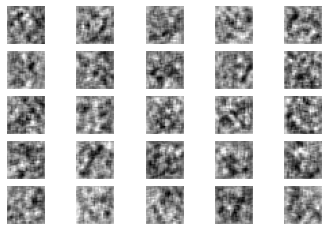

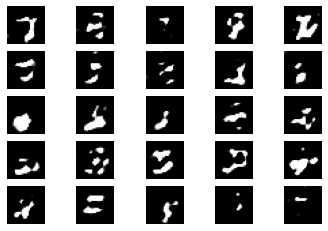

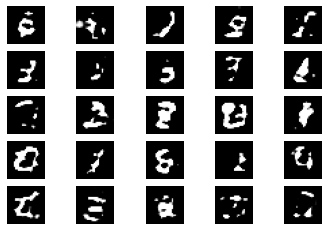

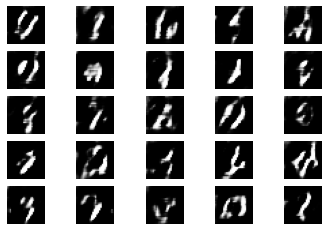

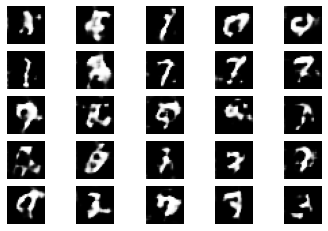

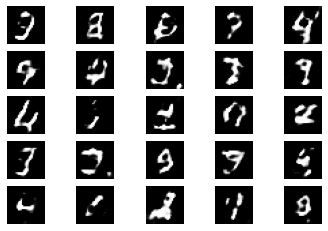

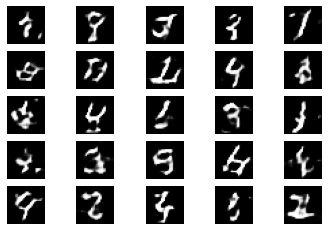

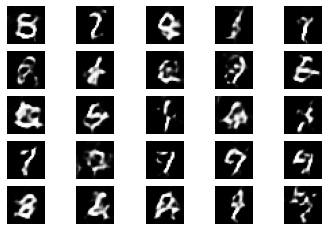

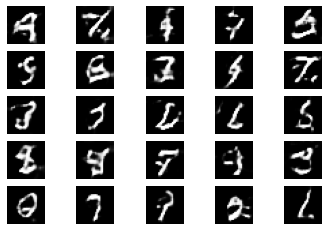

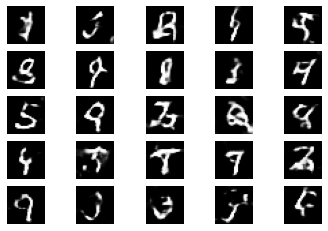

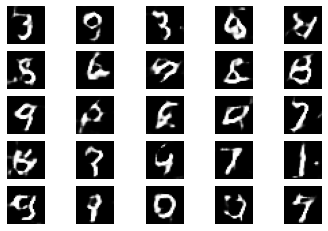

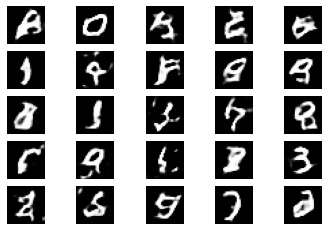

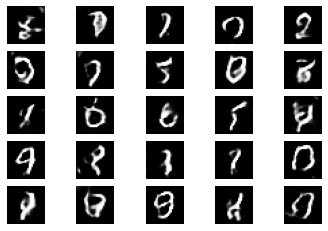

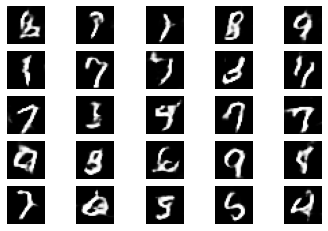

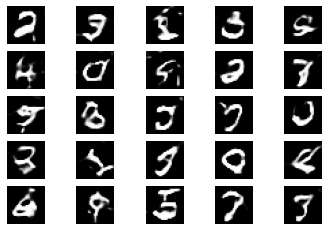

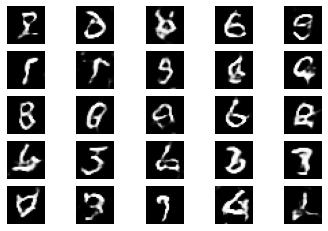

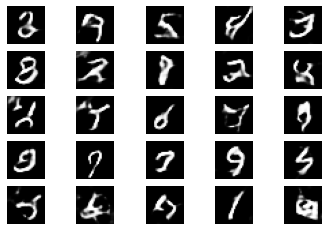

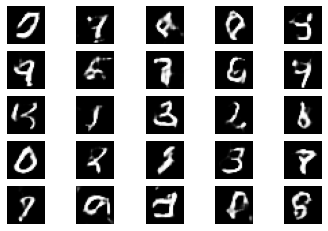

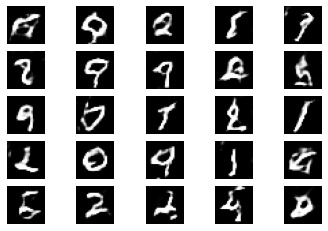

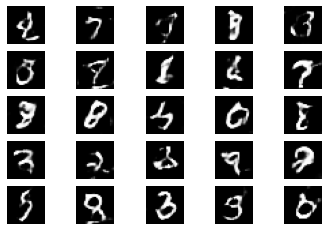

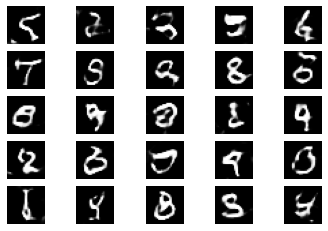

In [23]:
# 4,000번 반복되 (+1을 하는 것에 주의), 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)